In [ ]:
!gdown 16MDItRjOvlbm1rk8hD_OZibWTAu7zAqB
!gdown 1JY_tmHxVjkhznNe46y1LNzrNGYwRUQBj
!gdown 1qwwr3bYgFPbaRfxjVpXVNC7fZWBx7SgD

Downloading...
From: https://drive.google.com/uc?id=16MDItRjOvlbm1rk8hD_OZibWTAu7zAqB
To: /content/unet_weights.pth
100% 4.25M/4.25M [00:00<00:00, 97.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JY_tmHxVjkhznNe46y1LNzrNGYwRUQBj
To: /content/transformer_unet_opt.pth
100% 8.47M/8.47M [00:00<00:00, 17.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1qwwr3bYgFPbaRfxjVpXVNC7fZWBx7SgD
From (redirected): https://drive.google.com/uc?id=1qwwr3bYgFPbaRfxjVpXVNC7fZWBx7SgD&confirm=t&uuid=d5519e06-6cf0-4907-b795-aaf2f6074c47
To: /content/transformer_unet_weights.pth
100% 192M/192M [00:01<00:00, 150MB/s]


In [ ]:
import torch
import torch.nn as nn
import math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import Resize
import os
from tqdm import tqdm
device='cuda'

In [ ]:
class Embed(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_emb=nn.Linear(768, 768).to('cuda')
    self.pos=torch.arange(start=0, end=256).to('cuda')
    self.emb=nn.Embedding(256, 768).to('cuda')
  def forward(self, x):
    p=self.patch_emb(x)
    e=self.emb(self.pos)
    return p+e

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, eps:int=10**-6):
    super().__init__()
    self.eps=eps
    self.gamma=nn.Parameter(torch.ones([1])).to('cuda')
    self.beta=nn.Parameter(torch.zeros([1])).to('cuda')
  def forward(self, x):
    mean=torch.mean(x, dim=-1, keepdim=True)
    std=torch.std(x, dim=-1, keepdim=True)
    return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, seq_len, d_model, h):
    super().__init__()
    self.seq_len=seq_len
    self.d_model=d_model
    self.h=h
    assert self.d_model%h == 0, 'restriction applied'
    self.d_k=d_model//h
    self.w_q=nn.Linear(d_model, d_model).to('cuda')
    self.w_k=nn.Linear(d_model, d_model).to('cuda')
    self.w_v=nn.Linear(d_model, d_model).to('cuda')
    self.w_o=nn.Linear(d_model, d_model).to('cuda')
  @staticmethod
  def attention_score(q, k, v, d_k, mask):
    val=q@k.transpose(-2,-1)/math.sqrt(d_k)
    if mask:
      torch.masked_fill(val, mask==0, 1e-9)
    val=torch.softmax(val, dim=-1)
    return val@v, val
  def forward(self, q, k, v, mask):
    q_=self.w_q(q).reshape(q.shape[0], q.shape[1], self.h, self.d_k).transpose(1,2)
    k_=self.w_k(k).reshape(k.shape[0], k.shape[1], self.h, self.d_k).transpose(1,2)
    v_=self.w_v(v).reshape(v.shape[0], v.shape[1], self.h, self.d_k).transpose(1,2)
    x, attn_score=MultiHeadAttention.attention_score(q_,k_,v_,self.d_k,mask)
    x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
    return self.w_o(x)

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, dff):
    super().__init__()
    self.linear1=nn.Linear(d_model, dff).to('cuda')
    self.linear2=nn.Linear(dff, d_model).to('cuda')
  def forward(self, x):
    x=self.linear2(torch.relu(self.linear1(x)))
    return x

In [ ]:
class ResidualNet(nn.Module):
  def __init__(self, norm: LayerNormalization):
    super().__init__()
    self.norm=norm
  def forward(self, x, sublayer):
    return x + sublayer(self.norm(x))

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, self_attention: MultiHeadAttention, feed_forward: FeedForward, resnet: ResidualNet):
    super().__init__()
    self.self_attention=self_attention
    self.feed_forward=feed_forward
    self.sub_layer=nn.ModuleList([resnet for _ in range(2)])
  def forward(self, x, src_mask):
    x=self.sub_layer[0](x, lambda x: self.self_attention(x,x,x, src_mask))
    x=self.sub_layer[1](x, lambda x: self.feed_forward(x))
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, norm:LayerNormalization, layers:nn.ModuleList):
    super().__init__()
    self.layers=layers
    self.norm=norm
  def forward(self, x, mask):
    final=[]
    for i,layer in enumerate(self.layers):
      x=layer(x, mask)
      if i+1 in [3,6,9,12]:
        final.append(x)
    return self.norm(x), final

In [ ]:
class Transformer(nn.Module):
  def __init__(self, embed, encoder):
    super().__init__()
    self.emb=embed
    self.encoder=encoder
  def encode(self, x, mask):
    x=self.emb(x)
    return self.encoder(x, mask)

In [ ]:
def build_transformer(len=256, d_model=768, h=6, N=12, dff=1024):

  blocks1=[]
  for _ in range(N):
    en_self_attention=MultiHeadAttention(len, d_model, h).to('cuda')
    feed_forward=FeedForward(d_model, dff).to('cuda')
    resnet=ResidualNet(LayerNormalization()).to('cuda')
    blocks1.append(EncoderBlock(en_self_attention, feed_forward, resnet))


  enc=Encoder(LayerNormalization(),nn.ModuleList(blocks1))
  emb=Embed()

  transformer=Transformer(emb, enc)

  return transformer

In [ ]:
class conv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv=nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1).to('cuda'),
            nn.BatchNorm2d(out_c).to('cuda'),
            nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

In [ ]:
class deconv(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.deconv=nn.Sequential(nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)).to('cuda')
  def forward(self, x):
    return self.deconv(x)

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    #decoder 1
    self.l1=nn.Sequential(deconv(768, 64))
    self.m1=nn.Sequential(
            deconv(768, 64),
            conv(64, 64)
        )
    self.k1=nn.Sequential(
        conv(64+64, 64),
        conv(64, 64)
    )

    #decoder 2
    self.l2=nn.Sequential(deconv(64, 32))
    self.m2=nn.Sequential(
            deconv(768, 64),
            conv(64, 32),
            deconv(32, 32),
            conv(32, 32)
        )
    self.k2=nn.Sequential(
        conv(32+32, 32),
        conv(32, 32)
    )

    #decoder 3
    self.l3=nn.Sequential(deconv(32, 16))
    self.m3=nn.Sequential(
            deconv(768, 64),
            conv(64, 32),
            deconv(32, 32),
            conv(32, 32),
            deconv(32, 16),
            conv(16, 16)
        )
    self.k3=nn.Sequential(
        conv(16+16, 16),
        conv(16, 16)
    )

    #decoder 4
    self.l4=nn.Sequential(deconv(16, 4))

    self.k4=nn.Sequential(
        conv(3, 4),
        conv(4, 4)
    )

    self.k5=nn.Sequential(
        conv(4+4, 4),
        conv(4,4))

    #outp
    self.g=nn.Conv2d(4,1, kernel_size=1).to(device)

  def forward(self, u, z12, z9, z6, z3):
    x=self.l1(z12)
    c=self.m1(z9)
    x=torch.cat([x,c], dim=1)
    x=self.k1(x)


    x=self.l2(x)
    c=self.m2(z6)
    x=torch.cat([x,c], dim=1)
    x=self.k2(x)

    x=self.l3(x)
    c=self.m3(z3)
    x=torch.cat([x,c], dim=1)
    x=self.k3(x)

    x=self.l4(x)
    c=self.k4(u)
    x=torch.cat([x,c], dim=1)
    x=self.k5(x)

    x=self.g(x)

    return x

In [ ]:
import os
y=os.path.join('/content/drive/MyDrive/BraTS20_Training_167')
dir=[os.path.join(y,y) for i in os.listdir(y) if '.csv' not in i]

In [ ]:
dir=y

In [ ]:
def tensor(dir):
    t=[]
    l=[]
    for i in ['flair', 't1', 't1ce', 't2']:
        t.append(nib.load(dir+'/BraTS20_Training_167'+'_'+i+'.nii').get_fdata())
    l.append(nib.load(dir+'/BraTS20_Training_167'+'_seg.nii').get_fdata())
    y0=torch.tensor(t[0][:,:,:]).detach()
    y1=torch.tensor(t[1][:,:,:]).detach()
    y2=torch.tensor(t[2][:,:,:]).detach()
    #y3=torch.tensor(t[3][:,:,:]).detach()
    y4=torch.tensor(l[0][:,:,:]).detach()
    n=torch.cat((y0[:,:,0].detach().clone().reshape(-1,240,240),y1[:,:,0].detach().clone().reshape(-1,240,240),y2[:,:,0].detach().clone().reshape(-1,240,240)),0).unsqueeze_(0)
    n1=y4[:,:,0].detach().clone().reshape(-1,240,240).unsqueeze_(0)
    for i in range(36,110):
        n=torch.cat((n,torch.cat((y0[:,:,i].detach().clone().reshape(-1,240,240),y1[:,:,i].detach().clone().reshape(-1,240,240),y2[:,:,i].detach().clone().reshape(-1,240,240)),0).unsqueeze_(0)))
        n1=torch.cat((n1,y4[:,:,i].detach().clone().reshape(-1,240,240).unsqueeze_(0)))
    sz=Resize(256)
    p=sz(n)
    p1=sz(n1)
    p=p.reshape(-1,3,256,256).type(torch.float32).to('cuda').detach()
    p1=p1.reshape(-1,1,256,256).type(torch.float32).to('cuda').detach()
    t=torch.randn(75).type(torch.float32).to('cuda').detach()
    return p,p1,t

In [ ]:
u,p1,_=tensor(y)
t=u.view(75,256,-1)

In [ ]:
u.shape

torch.Size([75, 3, 256, 256])

In [ ]:
import csv
f= open('/content/drive/MyDrive/unetr_eval.csv', 'a+')
s=csv.writer(f)
s.writerow(['Loss', 'Accuracy', 'Dice', 'IoU', 'Hausdorff distance'])

43

In [ ]:
from torch import optim, nn

b=build_transformer().to(device)
dec=Decoder().to(device)
#opt1=optim.Adam(b.parameters(), lr=1e-4)
opt2=optim.Adam(dec.parameters(), lr=1e-2)
l1=nn.MSELoss()
epochs=10
#b.load_state_dict(torch.load('/content/drive/MyDrive/transformer_unet_weights.pth'))
#dec.load_state_dict(torch.load('/content/drive/MyDrive/unet_weights.pth'))
#opt2.load_state_dict(torch.load('/content/drive/MyDrive/transformer_unet_opt.pth'))

In [ ]:
from tqdm import tqdm
pbar=tqdm(range(1000))
for i in pbar:
  #opt1.zero_grad()
  opt2.zero_grad()
  z,f=b.encode(t, None)
  z3=f[0].reshape(-1,768,16,16)
  z6=f[1].reshape(-1,768,16,16)
  z9=f[2].reshape(-1,768,16,16)
  z12=f[3].reshape(-1,768,16,16)
  r=dec(t.reshape(75, 3, 256, 256), z12, z9, z6, z3)
  loss=l1(r,p1)
  loss.backward()
  #opt1.step()
  opt2.step()
  pbar.set_description(f'Epoch {i+1}/1000')
  pbar.set_postfix(loss=loss.item())
  s.writerow([loss.item(), calculate_accuracy(r[35:95],p1[35:95]), calculate_dice_coefficient(r[35:95],p1[35:95]), intersection_over_union(r[35:95],p1[35:95]), hausdorff_distance(r[35:95].cpu(),p1[35:95].cpu())])

Epoch 1000/1000: 100%|██████████| 1000/1000 [41:28<00:00,  2.49s/it, loss=0.00127]


In [ ]:
torch.save(b.state_dict(), '/content/drive/MyDrive/transformer_unet_weights.pth')
torch.save(dec.state_dict(), '/content/drive/MyDrive/unet_weights.pth')
torch.save(opt2.state_dict(), '/content/drive/MyDrive/transformer_unet_opt.pth')

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import cv2

def calculate_f1_score(outputs, targets, threshold=0.2):
    outputs = (outputs > threshold).float()
    targets = (targets > 0.2).float()

    true_positives = torch.sum(outputs * targets)
    predicted_positives = torch.sum(outputs)
    actual_positives = torch.sum(targets)

    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)

    f1_score = 2.0 * (precision * recall) / (precision + recall + 1e-7)

    return f1_score.item()

def calculate_precision(outputs, targets, threshold=0.2):
    outputs = (outputs > threshold).float()
    targets = (targets > 0.2).float()

    true_positives = torch.sum(outputs * targets)
    predicted_positives = torch.sum(outputs)

    precision = true_positives / (predicted_positives + 1e-7)

    return precision.item()

def calculate_accuracy(r, p1, threshold=0.2):
    p1 = (p1 - p1.min()) / (p1.max() - p1.min())
    targets=p1.view(-1,128,128)
    r = (r - r.min()) / (r.max() - r.min())
    r[r<0.05]=0
    outputs=r.view(-1,128,128)
    outputs = (outputs > threshold).float()
    targets = (targets > 0.2).float()

    correct = torch.sum(outputs == targets)
    total = torch.prod(torch.tensor(targets.size())).float()

    accuracy = correct / total

    return accuracy.item()

def calculate_recall(outputs, targets, threshold=0.2):
    outputs = (outputs > threshold).float()
    targets = (targets > 0.2).float()

    true_positives = torch.sum(outputs * targets)
    actual_positives = torch.sum(targets)

    recall = true_positives / (actual_positives + 1e-7)

    return recall.item()


def soft_iou(outputs, targets, threshold=0.2):
    outputs_bin = (outputs > threshold).float()
    targets_bin = (targets > 0.2).float()

    intersection = torch.sum(outputs_bin * targets_bin)
    union = torch.sum(outputs_bin) + torch.sum(targets_bin) - intersection
    soft_iou = intersection / (union + 1e-7)

    return soft_iou.item()

def intersection_over_union(r, p1, threshold=0.2):

    p1 = (p1 - p1.min()) / (p1.max() - p1.min())
    targets=p1.view(-1,128,128)
    r = (r - r.min()) / (r.max() - r.min())
    r[r<0.05]=0
    outputs=r.view(-1,128,128)
    outputs = (outputs > threshold).float()
    targets = (targets > threshold).float()

    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets) - intersection
    iou = intersection / (union + 1e-7)

    return iou.item()

def surface_dice_similarity_coefficient(outputs, targets, threshold=0.2):

    outputs = (outputs > threshold).float()
    targets = (targets > threshold).float()

    surface_dice = (2.0 * torch.sum(outputs * targets) + 1e-7) / (torch.sum(outputs) + torch.sum(targets) + 1e-7)

    return surface_dice.item()

def precision_recall_curve(outputs, targets, threshold_range=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    precisions = []
    recalls = []

    for threshold in threshold_range:
        outputs_bin = (outputs > threshold).float()
        targets_bin = (targets > threshold).float()

        true_positives = torch.sum(outputs_bin * targets_bin)
        false_positives = torch.sum(outputs_bin * (1 - targets_bin))
        false_negatives = torch.sum((1 - outputs_bin) * targets_bin)

        precision = true_positives / (true_positives + false_positives + 1e-7)
        recall = true_positives / (true_positives + false_negatives + 1e-7)

        precisions.append(precision.item())
        recalls.append(recall.item())

    return {"Precision": precisions, "Recall": recalls}

def mean_average_precision(precisions, recalls):

    interpolated_precisions = [max(precisions[i:]) for i in range(len(precisions))]
    mAP = np.mean(interpolated_precisions)

    return mAP
def hausdorff_distance(r, p1, threshold=0.1):

    p1 = (p1 - p1.min()) / (p1.max() - p1.min())
    targets=p1.view(-1,128,128)
    r = (r - r.min()) / (r.max() - r.min())
    r[r<0.05]=0
    outputs=r.view(-1,128,128)
    outputs = (outputs > threshold).float()
    targets = (targets > threshold).float()

    pred_boundary = _get_boundary(outputs)
    gt_boundary = _get_boundary(targets)

    hausdorff_dist = directed_hausdorff(pred_boundary, gt_boundary)[0]

    return hausdorff_dist

def calculate_dice_coefficient(r, p1, threshold=0.2):

    p1 = (p1 - p1.min()) / (p1.max() - p1.min())
    targets=p1.view(-1,128,128)
    r = (r - r.min()) / (r.max() - r.min())
    r[r<0.05]=0
    outputs=r.view(-1,128,128)
    outputs = (outputs > threshold).float()
    targets = (targets > threshold).float()

    intersection = torch.sum(outputs * targets)
    dice_coefficient = (2.0 * intersection + 1e-7) / (torch.sum(outputs) + torch.sum(targets) + 1e-7)  # Add epsilon to avoid division by zero

    return dice_coefficient.item()


def average_symmetric_surface_distance(outputs, targets, threshold=0.1):
    outputs = (outputs > threshold).float()
    targets = (targets > threshold).float()
    pred_boundary = _get_boundary(outputs)
    gt_boundary = _get_boundary(targets)
    ssd_pred_to_gt = _surface_distance(pred_boundary, gt_boundary)
    ssd_gt_to_pred = _surface_distance(gt_boundary, pred_boundary)
    assd = (ssd_pred_to_gt + ssd_gt_to_pred) / 2.0

    return assd.item()

def _get_boundary(mask):
    boundary = []
    for batch in mask:
      contours, _ = cv2.findContours((batch.numpy() * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      for contour in contours:
          contour = contour.squeeze()
          if len(contour.shape) == 1:
              contour = np.expand_dims(contour, axis=0)
          boundary.extend(contour.tolist())
    return np.array(boundary)

def _surface_distance(pred_boundary, gt_boundary):
    if len(pred_boundary) == 0 or len(gt_boundary) == 0:
        return np.inf

    distances = np.linalg.norm(pred_boundary[:, None] - gt_boundary[None, :], axis=-1)
    min_distances = np.min(distances, axis=1)

    return np.mean(min_distances)

       Loss  Accuracy      Dice       IoU  Hausdorff distance
0  0.106189  0.024171  0.047184  0.024162           80.919713
1  0.085885  0.024958  0.047196  0.024168           80.919713
2  0.055861  0.032134  0.047540  0.024349           80.919713
3  0.037076  0.103147  0.050979  0.026156           80.919713
4  0.025657  0.461262  0.081547  0.042507           80.919713


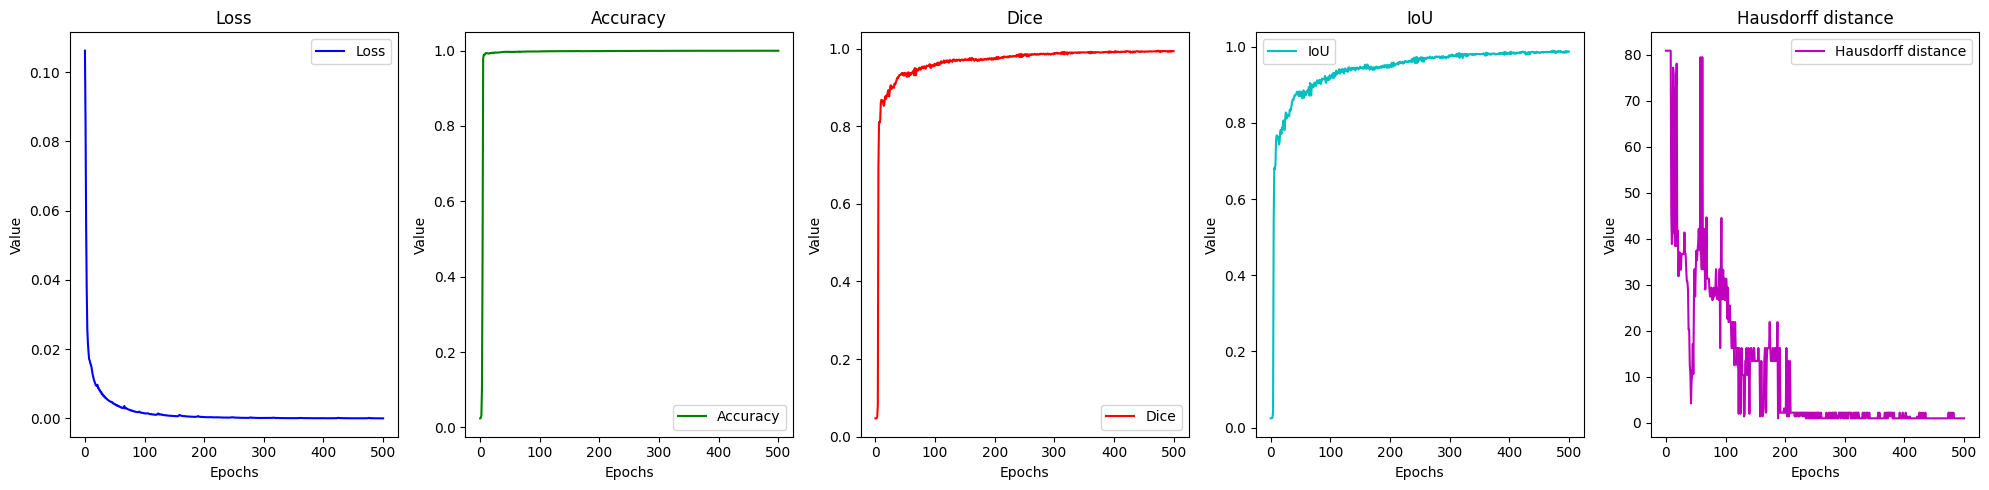

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
csv_file = '/content/drive/MyDrive/unet_main_eval.csv'
df = pd.read_csv(csv_file)
print(df.head())
num_columns = len(df.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(20, 5))
if num_columns == 1:
    axes = [axes]
colors = ['b', 'g', 'r', 'c', 'm']
for i, column in enumerate(df.columns):
    axes[i].plot(df[column], color=colors[i], label=column)
    axes[i].set_title(column)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Value')
    axes[i].legend()
plt.tight_layout()
plt.show()
